# Loading the dataset and importing libraries


In [ ]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from numpy import fft
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

from app import EvaluateAndReport, add_features, plot_features, to_RGB, get_distrib

In [ ]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

#returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

Mounted at /content/drive


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [ ]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


# Data treatment

In [ ]:
# Train/test split
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)

In [ ]:
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


In [ ]:
naive_base = X = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

In [ ]:
# splitting the bands into single elements
df = df.join(naive_base)

In [ ]:
df.head()

,id,band_1,band_2,inc_angle,is_iceberg,band_1_0,band_1_1,band_1_2,band_1_3,band_1_4,band_1_5,band_1_6,band_1_7,band_1_8,band_1_9,band_1_10,band_1_11,band_1_12,band_1_13,band_1_14,band_1_15,band_1_16,band_1_17,band_1_18,band_1_19,band_1_20,band_1_21,band_1_22,band_1_23,band_1_24,band_1_25,band_1_26,band_1_27,band_1_28,band_1_29,band_1_30,band_1_31,band_1_32,band_1_33,band_1_34,...,band_2_5585,band_2_5586,band_2_5587,band_2_5588,band_2_5589,band_2_5590,band_2_5591,band_2_5592,band_2_5593,band_2_5594,band_2_5595,band_2_5596,band_2_5597,band_2_5598,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624
530,f06ecb96,"[-22.622971, -19.042347, -18.257372, -18.69734...","[-23.36264, -22.62306, -23.962086, -24.38596, ...",30.4878,1,-22.622971,-19.042347,-18.257372,-18.697346,-20.440437,-20.440529,-16.872957,-18.697704,-17.637222,-14.771990,-15.064069,-18.366076,-18.698151,-19.281404,-18.366344,-17.058575,-19.281673,-21.310917,-18.698689,-17.738623,-20.305080,-19.526810,-18.047298,-16.874477,-17.153282,-17.840750,-17.441418,-16.604786,-17.153641,-17.739517,-17.441776,-16.694231,-15.368186,-14.774137,-16.694500,...,-24.389721,-23.366758,-21.313601,-22.627266,-24.390078,-21.945848,-24.390257,-22.280142,-21.314140,-20.868700,-22.111748,-24.836233,-24.610701,-23.762714,-21.784298,-21.314764,-22.112286,-24.176765,-23.368282,-23.967636,-26.605476,-23.967815,-26.062611,-25.551620,-22.453671,-23.763790,-25.803671,-24.392139,-23.968441,-22.282114,-21.948090,-22.282293,-24.178108,-24.392677,-22.992010,-22.282654,-22.282743,-23.764866,-25.308275,-23.969429
1140,974931df,"[-27.235119, -26.907366, -24.170664, -24.17072...","[-32.01276, -29.514042, -26.907423, -29.090368...",38.4591,1,-27.235119,-26.907366,-24.170664,-24.170721,-24.653395,-23.279133,-29.959793,-27.930696,-27.930754,-22.865665,-20.727779,-19.972065,-25.432146,-28.686749,-25.432259,-24.409208,-22.666262,-26.908094,-24.171391,-21.556082,-20.887661,-20.887661,-23.279917,-25.993223,-25.993280,-23.070776,-23.070776,-23.494617,-25.708639,-27.577129,-30.927008,-30.430592,-30.430592,-25.433098,-26.908876,...,-27.934340,-31.456221,-29.094288,-29.094288,-29.094345,-29.518187,-27.580044,-25.711666,-26.911680,-29.094570,-28.304455,-29.963997,-28.304567,-29.518581,-29.518581,-29.094851,-29.094906,-32.017525,-31.457005,-30.434010,-32.017635,-34.711662,-27.935349,-25.997204,-27.240219,-29.095299,-28.691288,-25.436798,-24.910276,-28.305351,-28.691511,-29.964893,-29.095634,-27.581276,-27.935907,-29.965117,-29.095804,-28.305687,-29.095917,-30.931379
168,d6566373,"[-28.63821, -26.238758, -29.042387, -29.042442...","[-25.944237, -25.659485, -28.252216, -31.40442...",39.5048,0,-28.638210,-26.238758,-29.042387,-29.042442,-25.944458,-25.944511,-27.528191,-27.187578,-29.042713,-29.466555,-29.912138,-31.965439,-36.402470,-36.402470,-33.208508,-30.381977,-28.252926,-27.188070,-25.945168,-26.860371,-27.883476,-29.467155,-29.467211,-27.188398,-27.188452,-28.253418,-28.639574,-28.639574,-30.879105,-28.639683,-28.253635,-28.253691,-25.945875,-25.945930,-27.529612,...,-28.255329,-30.384491,-26.862720,-26.546890,-26.862829,-27.190638,-28.641705,-29.915142,-28.641815,-27.886101,-28.255823,-27.531633,-27.531689,-27.191076,-25.663364,-24.609291,-27.191238,-29.915688,-29.915688,-29.046431,-29.046486,-29.915852,-31.969154,-33.212170,-31.408689,-27.886921,-29.046812,-28.256699,-26.243347,-26.548203,-27.191952,-25.121138,-26.243513,-28.643074,-29.916512,-31.409237,-32.569130,-27.887520,-24.127768,-25.664623
135,6706ea46,"[-22.52327, -20.36145, -18.631905, -19.001574,...","[-26.236002, -27.819691, -25.408276, -25.14897...",36.1091,1,-22.523270,-20.361450,-18.631905,-19.001574,-19.257124,-18.753517,-21.974827,-20.661316,-20.215853,-19.388000,-21.131067,-21.458941,-19.93123

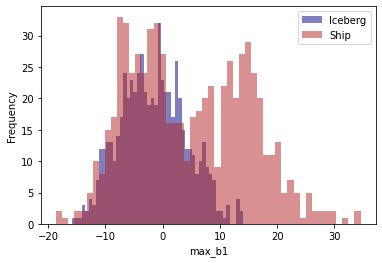

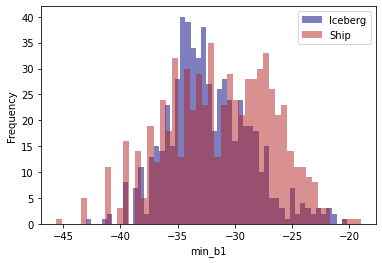

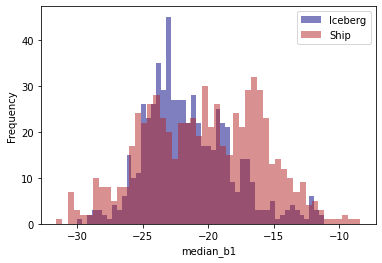

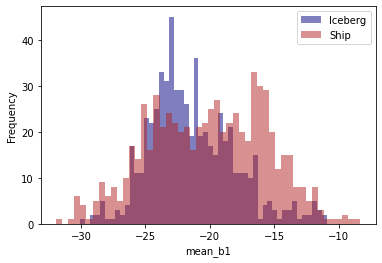

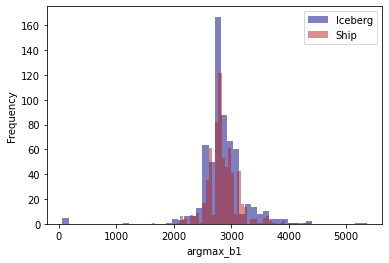

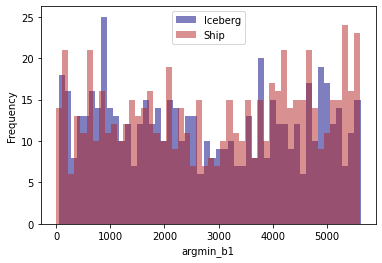

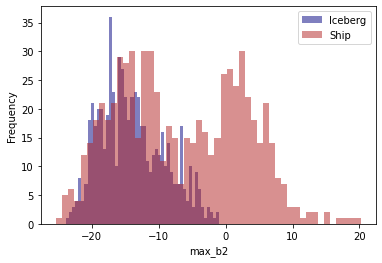

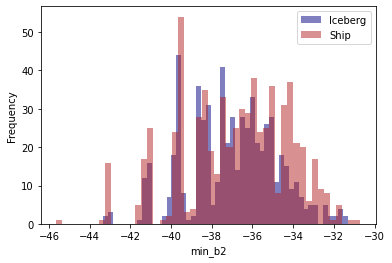

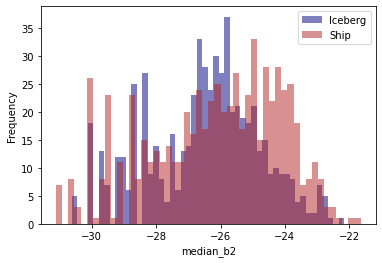

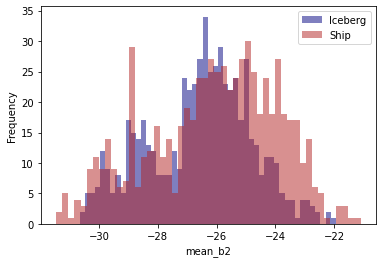

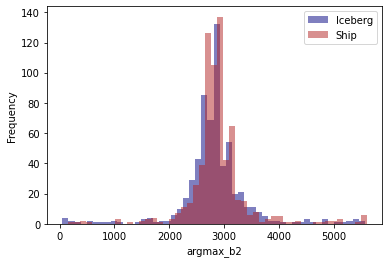

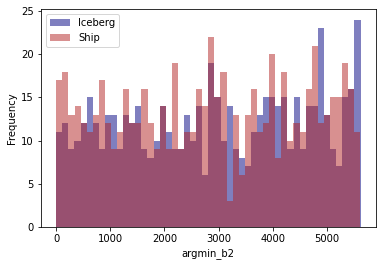

In [ ]:
# applying the above function 
df = add_features(df,1)
df = add_features(df,2)

# plotting the variables
for i in [1,2] :
  for col in ['max_b'+str(i),'min_b'+str(i),'median_b'+str(i),'mean_b'+str(i),'argmax_b'+str(i),'argmin_b'+str(i)]:
    plot_features(df, col)

## Matrice de corrélation

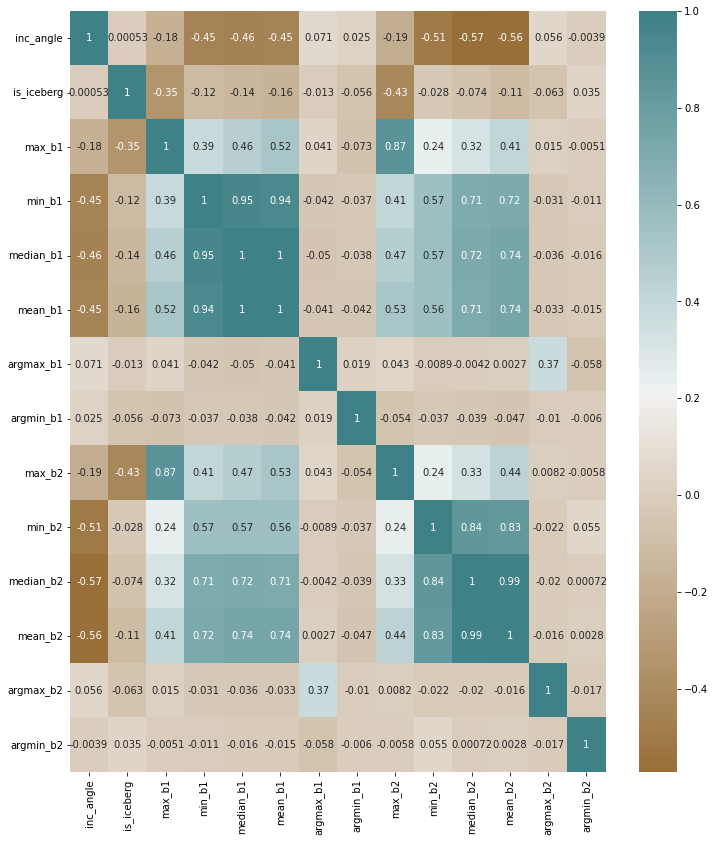

In [ ]:
stats_corr = df.drop([f"band_1_{i}" for i in range(75*75)]+[f"band_2_{i}" for i in range(75*75)],axis=1).corr()
plt.figure(figsize = (12,14))
ax = sns.heatmap(stats_corr, annot = True, cmap = sns.diverging_palette(50, 200, n=200))

# Results

## On statistics only

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

# selecting the prediction target and the model features
y = df["is_iceberg"]
X_stats = df.loc[:,['max_b1','min_b1','median_b1','mean_b1','argmax_b1','argmin_b1','max_b2','min_b2','median_b2','mean_b2','argmax_b2','argmin_b2']]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)

### DecisionTreeClassifier

In [ ]:
X_stats

,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2
530,-0.897075,-29.583092,-18.048462,-18.112508,2667,4169,-14.703813,-31.325020,-22.802425,-22.830266,2741,4083
1140,-5.598961,-36.454388,-26.289146,-26.294448,2888,4634,-23.071953,-38.634918,-29.091711,-29.087352,51,1090
168,-8.369424,-39.927570,-27.886208,-28.104746,3124,4853,-17.648048,-39.926807,-28.255713,-28.530522,3198,1629
135,-6.444110,-31.174166,-19.936411,-20.070621,2732,2541,-18.755909,-36.697906,-26.532661,-26.580998,2205,899
438,8.382858,-31.131157,-20.250298,-19.967787,3187,258,-2.915977,-39.649490,-27.980453,-27.961630,3187,2931
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,-6.607138,-38.072559,-22.509045,-22.704236,2735,4866,-18.322495,-33.390518,-24.604317,-24.899377,4667,4332
16,-8.202933,-34.144661,-23.608482,-23.678953,2960,4319,-18.849331,-36.909927,-25.145733,-25.384818,5527,3175
1072,-7.761281,-39.508995,-28.626736,-28.777052,2974,3448,-12.464365,-43.029026,-29.050724,-29.288303,2974,340
1579,-9.798533,-30.373240,-18.104858,-18.139073,2885,41,-13.804255,-36.862823,-25.579882,-25.782242,2735,4743


--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.68
--- Cross Validation Report ---
Mean accuracy score 0.703 with std 0.044
Mean f1 score 0.687 with std 0.046
Mean precision score 0.682 with std 0.047
Mean recall score 0.693 with std 0.048
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.701
 f1 : 0.69
 precision : 0.699
 recall : 0.682
Confusion matrix for the test sample :


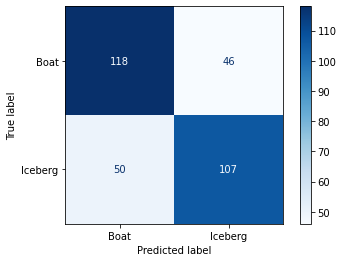

In [ ]:
df_stats = df.loc[:,['id','is_iceberg','inc_angle','is_iceberg','max_b1','min_b1','median_b1','mean_b1','argmax_b1','argmin_b1','max_b2','min_b2','median_b2','mean_b2','argmax_b2','argmin_b2']]
er = EvaluateAndReport(df_stats, X_train, X_test, y_train, y_test)

param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.cv_cv = 5
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)

In [ ]:
er.cross_proba_report()

--- Cross Validation with 0.5 Threshold Report ---
 accuracy : 0.7
 f1 : 0.697
 precision : 0.664
 recall : 0.733


--- Precision Recall Curves ---


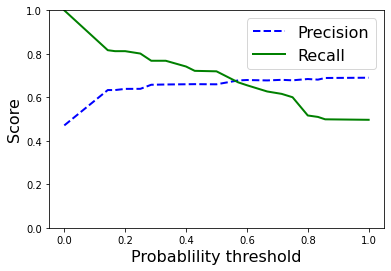

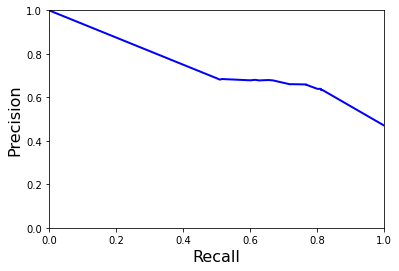

In [ ]:
er.plot_precision_recall()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') :
 {'n_neighbors': 12} with f1 score 0.367
--- Cross Validation Report ---
Mean accuracy score 0.522 with std 0.03
Mean f1 score 0.367 with std 0.053
Mean precision score 0.485 with std 0.048
Mean recall score 0.296 with std 0.052
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.505
 f1 : 0.367
 precision : 0.489
 recall : 0.293
Confusion matrix for the test sample :


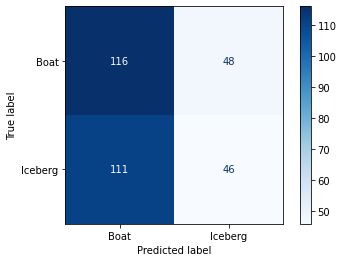

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 5
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)

## On PCA data only

In [ ]:
from app import get_pca_df
pca_5 = get_pca_df(df, naive_base, 5)
pca_10 = get_pca_df(df, naive_base, 10)
pca_20 = get_pca_df(df, naive_base, 20)
pca_50 = get_pca_df(df, naive_base, 50)
pca_100 = get_pca_df(df, naive_base, 100)
pca_200 = get_pca_df(df, naive_base, 200)
pca_500 = get_pca_df(df, naive_base, 500)

### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.626
--- Cross Validation Report ---
Mean accuracy score 0.68 with std 0.047
Mean f1 score 0.647 with std 0.058
Mean precision score 0.674 with std 0.055
Mean recall score 0.627 with std 0.078
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.667
 f1 : 0.662
 precision : 0.656
 recall : 0.669
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, crite

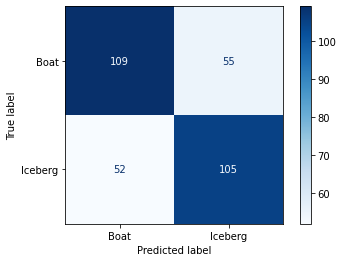

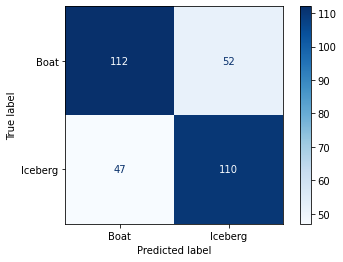

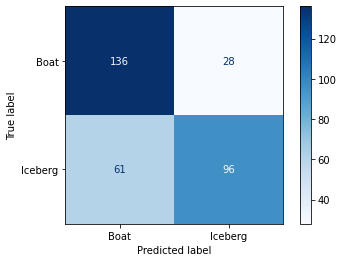

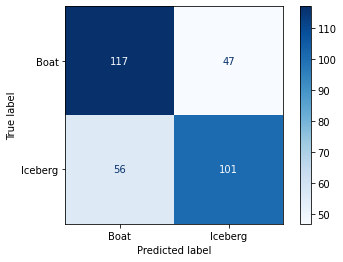

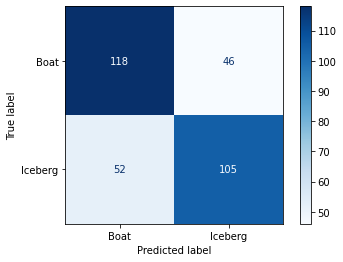

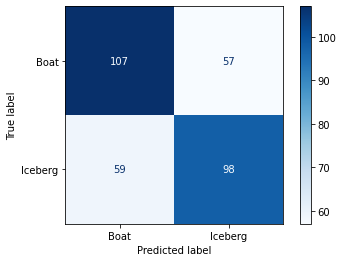

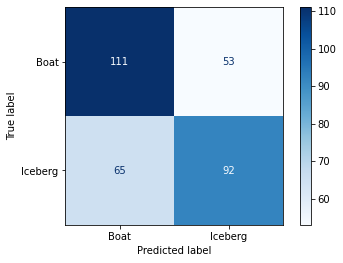

In [ ]:
param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.cv_cv = 5

train_scores = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores.append(er.best_scores_t)

In [ ]:
train_scores

[{'accuracy': 0.68, 'f1': 0.647, 'precision': 0.674, 'recall': 0.627},
 {'accuracy': 0.685, 'f1': 0.657, 'precision': 0.671, 'recall': 0.646},
 {'accuracy': 0.686, 'f1': 0.654, 'precision': 0.677, 'recall': 0.634},
 {'accuracy': 0.711, 'f1': 0.683, 'precision': 0.704, 'recall': 0.665},
 {'accuracy': 0.665, 'f1': 0.632, 'precision': 0.653, 'recall': 0.613},
 {'accuracy': 0.661, 'f1': 0.627, 'precision': 0.65, 'recall': 0.607},
 {'accuracy': 0.653, 'f1': 0.621, 'precision': 0.639, 'recall': 0.607}]

In [ ]:
x_plot = [5, 10, 20, 50, 100, 200, 500]
y_plot1 = [a.get('accuracy') for a in train_scores]
y_plot2 = [a.get('f1') for a in train_scores]
y_plot3 = [a.get('precision') for a in train_scores]
y_plot4 = [a.get('recall') for a in train_scores]

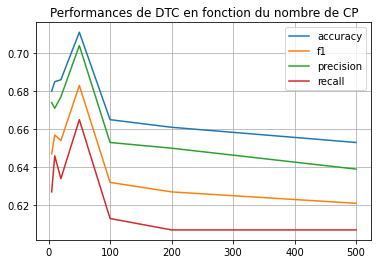

In [ ]:
plt.plot(x_plot, y_plot1, label='accuracy')
plt.plot(x_plot, y_plot2, label='f1')
plt.plot(x_plot, y_plot3, label='precision')
plt.plot(x_plot, y_plot4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP')
plt.grid(True)
plt.show()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') :
 {'n_neighbors': 16} with f1 score 0.677
--- Cross Validation Report ---
Mean accuracy score 0.684 with std 0.03
Mean f1 score 0.682 with std 0.035
Mean precision score 0.649 with std 0.03
Mean recall score 0.722 with std 0.067
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.701
 f1 : 0.711
 precision : 0.674
 recall : 0.752
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') :
 {'n_neighbors': 8} with f1 score 0.709
--- Cross Validation Report ---
Mean accuracy score 0.731 with std 0.037
Mean f1 score 0.715 with st

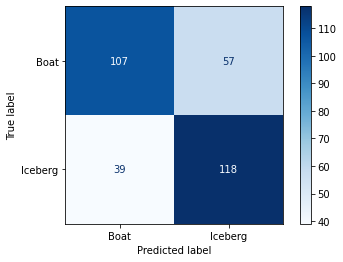

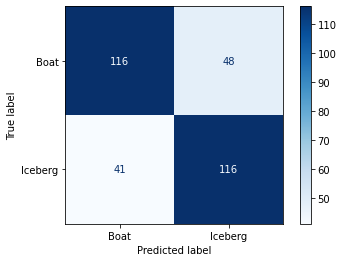

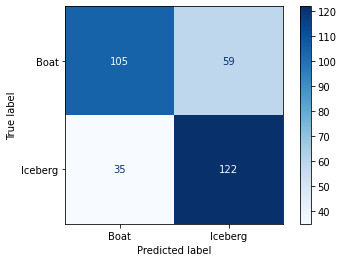

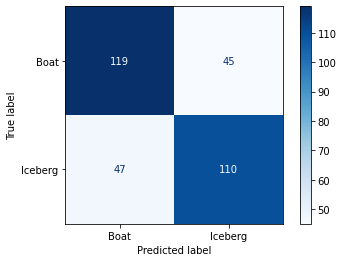

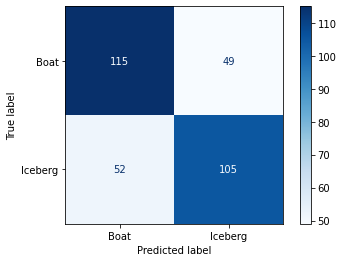

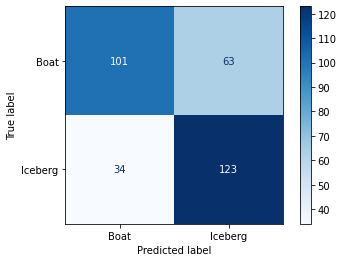

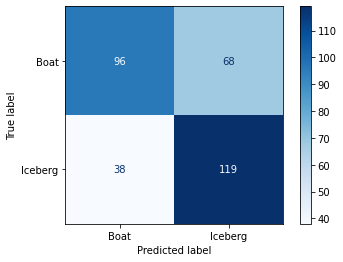

In [ ]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 5

train_scores_knn = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er.best_scores_t)

In [ ]:
y_p1 = [a.get('accuracy') for a in train_scores_knn]
y_p2 = [a.get('f1') for a in train_scores_knn]
y_p3 = [a.get('precision') for a in train_scores_knn]
y_p4 = [a.get('recall') for a in train_scores_knn]

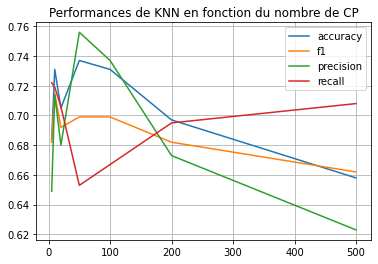

In [ ]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de KNN en fonction du nombre de CP')
plt.grid(True)
plt.show()

## On PCA and statistics

In [ ]:
df_stats = df_stats.loc[:,~df_stats.columns.duplicated()]
df_5 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_5.drop('is_iceberg',axis=1)).dropna()
df_20 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_20.drop('is_iceberg',axis=1)).dropna()
df_50 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_50.drop('is_iceberg',axis=1)).dropna()
df_100 = df_stats.drop(['inc_angle','id'],axis=1).join(pca_100.drop('is_iceberg',axis=1)).dropna()

### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.698
--- Cross Validation Report ---
Mean accuracy score 0.742 with std 0.056
Mean f1 score 0.718 with std 0.067
Mean precision score 0.74 with std 0.066
Mean recall score 0.7 with std 0.082
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.72
 f1 : 0.713
 precision : 0.713
 recall : 0.713
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterio

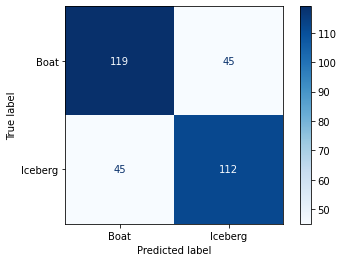

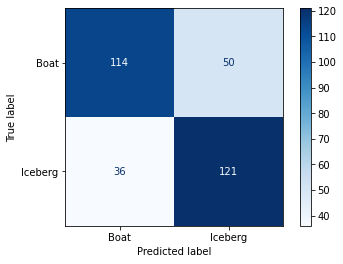

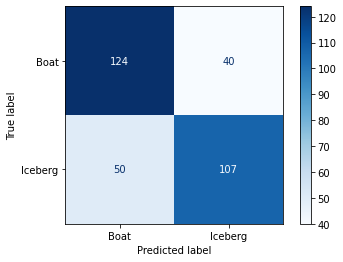

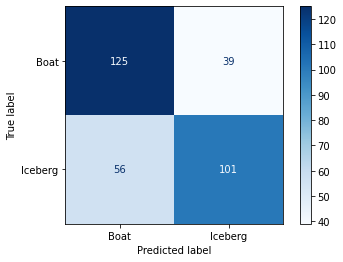

In [ ]:
train_scores_mix = []
for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop(['is_iceberg'],axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores_mix.append(er.best_scores_t)

In [ ]:
x_p = [5, 20, 50, 100]
y1 = [a.get('accuracy') for a in train_scores_mix]
y2 = [a.get('f1') for a in train_scores_mix]
y3 = [a.get('precision') for a in train_scores_mix]
y4 = [a.get('recall') for a in train_scores_mix]

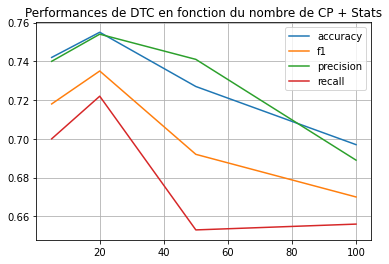

In [ ]:
plt.plot(x_p, y1, label='accuracy')
plt.plot(x_p, y2, label='f1')
plt.plot(x_p, y3, label='precision')
plt.plot(x_p, y4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP + Stats')
plt.grid(True)
plt.show()

# Labellising noisy images

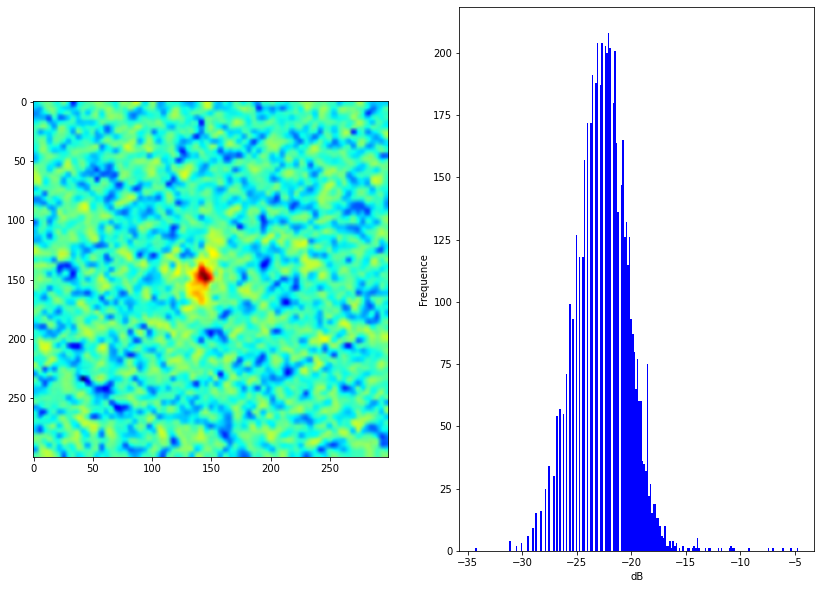

The kurtosis value :  2.8237831050119198


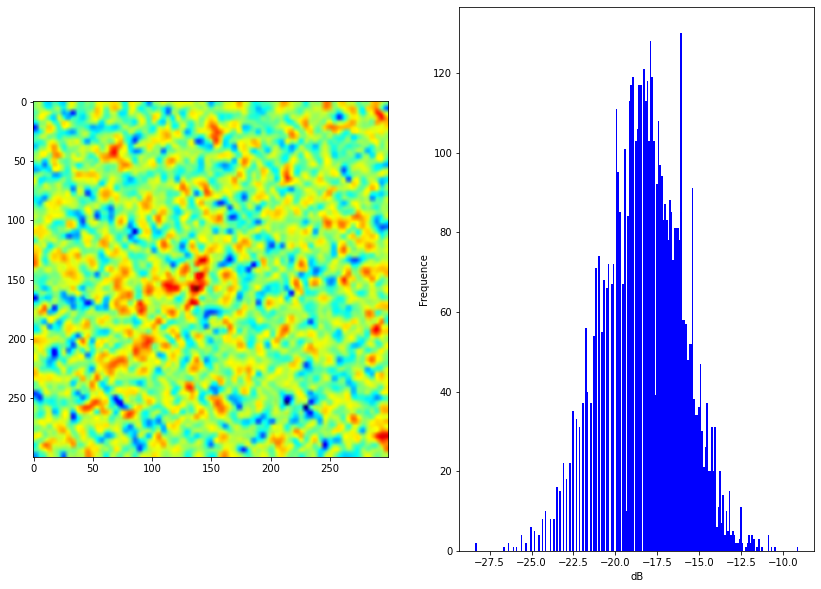

The kurtosis value :  0.3251085176423394


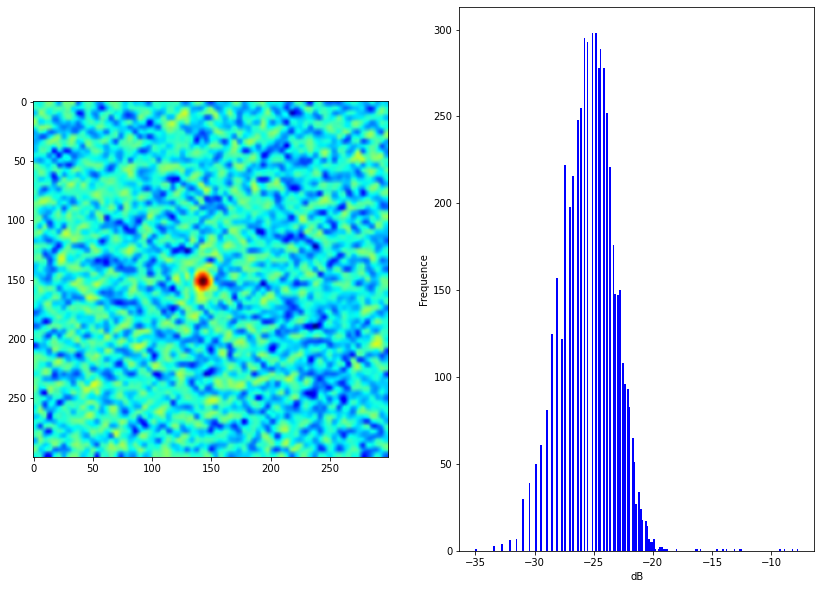

The kurtosis value :  2.9256614990836214


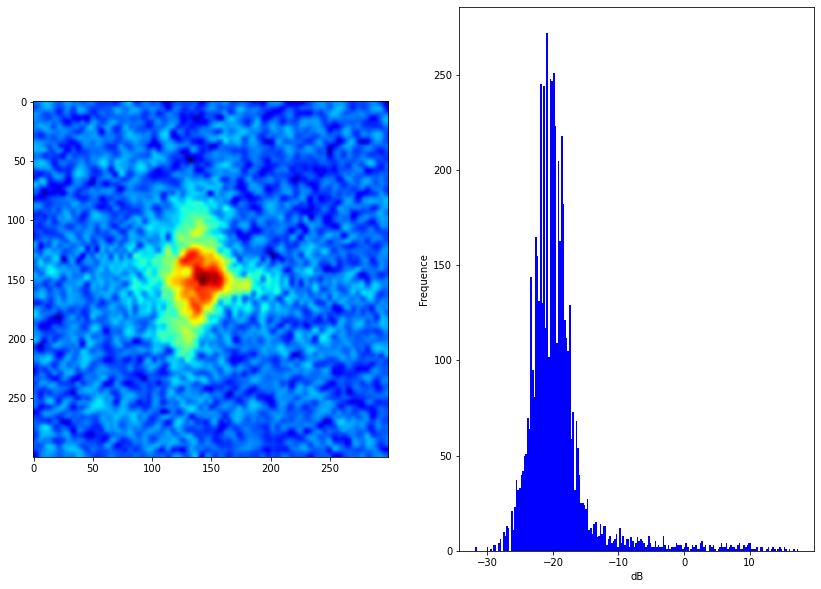

The kurtosis value :  13.452193729874228


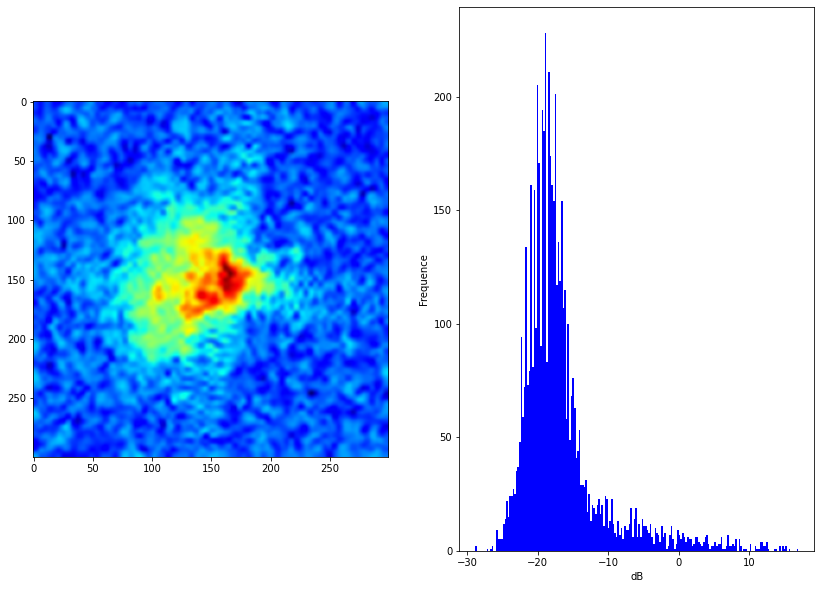

The kurtosis value :  6.137041559623947


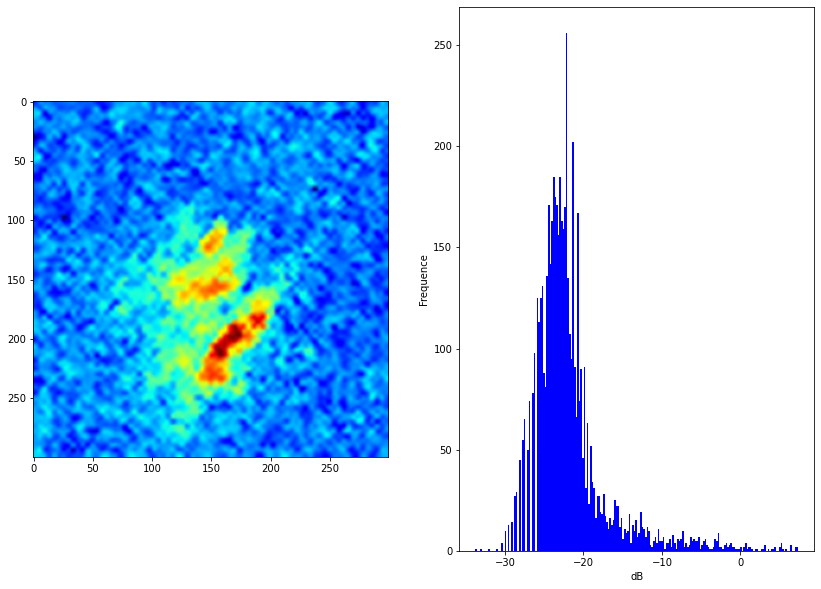

The kurtosis value :  7.193157461355089


In [ ]:
for i in [28, 29, 821, 25, 545, 900]: 
  img = get_distrib(np.array(df.iloc[i,1]))
  print("The kurtosis value : ", img.kurtosis)

In [ ]:
# We can see that noisy images have smaller kurtosis value (near 0 for the noisiest ones)
# which indicates that they are more closer to a normal distribution 
#for i in range(df.shape[0]):
df['noisy_b1'] = [1 if (get_distrib(np.array(matx), display=False).kurtosis < 3) else 0 for matx in df['band_1']]
df['noisy_b2'] = [1 if (get_distrib(np.array(matx), display=False).kurtosis < 3) else 0 for matx in df['band_2']]

In [ ]:
df.head()

,id,band_1,band_2,inc_angle,is_iceberg,band_1_0,band_1_1,band_1_2,band_1_3,band_1_4,band_1_5,band_1_6,band_1_7,band_1_8,band_1_9,band_1_10,band_1_11,band_1_12,band_1_13,band_1_14,band_1_15,band_1_16,band_1_17,band_1_18,band_1_19,band_1_20,band_1_21,band_1_22,band_1_23,band_1_24,band_1_25,band_1_26,band_1_27,band_1_28,band_1_29,band_1_30,band_1_31,band_1_32,band_1_33,band_1_34,...,band_2_5599,band_2_5600,band_2_5601,band_2_5602,band_2_5603,band_2_5604,band_2_5605,band_2_5606,band_2_5607,band_2_5608,band_2_5609,band_2_5610,band_2_5611,band_2_5612,band_2_5613,band_2_5614,band_2_5615,band_2_5616,band_2_5617,band_2_5618,band_2_5619,band_2_5620,band_2_5621,band_2_5622,band_2_5623,band_2_5624,max_b1,min_b1,median_b1,mean_b1,argmax_b1,argmin_b1,max_b2,min_b2,median_b2,mean_b2,argmax_b2,argmin_b2,noisy_b1,noisy_b2
530,f06ecb96,"[[-22.622971, -19.042347, -18.257372, -18.6973...","[[-23.36264, -22.62306, -23.962086, -24.38596,...",30.4878,1,-22.622971,-19.042347,-18.257372,-18.697346,-20.440437,-20.440529,-16.872957,-18.697704,-17.637222,-14.771990,-15.064069,-18.366076,-18.698151,-19.281404,-18.366344,-17.058575,-19.281673,-21.310917,-18.698689,-17.738623,-20.305080,-19.526810,-18.047298,-16.874477,-17.153282,-17.840750,-17.441418,-16.604786,-17.153641,-17.739517,-17.441776,-16.694231,-15.368186,-14.774137,-16.694500,...,-21.784298,-21.314764,-22.112286,-24.176765,-23.368282,-23.967636,-26.605476,-23.967815,-26.062611,-25.551620,-22.453671,-23.763790,-25.803671,-24.392139,-23.968441,-22.282114,-21.948090,-22.282293,-24.178108,-24.392677,-22.992010,-22.282654,-22.282743,-23.764866,-25.308275,-23.969429,-0.897075,-29.583092,-18.048462,-18.112508,2667,4169,-14.703813,-31.325020,-22.802425,-22.830266,2741,4083,0,1
1140,974931df,"[[-27.235119, -26.907366, -24.170664, -24.1707...","[[-32.01276, -29.514042, -26.907423, -29.09036...",38.4591,1,-27.235119,-26.907366,-24.170664,-24.170721,-24.653395,-23.279133,-29.959793,-27.930696,-27.930754,-22.865665,-20.727779,-19.972065,-25.432146,-28.686749,-25.432259,-24.409208,-22.666262,-26.908094,-24.171391,-21.556082,-20.887661,-20.887661,-23.279917,-25.993223,-25.993280,-23.070776,-23.070776,-23.494617,-25.708639,-27.577129,-30.927008,-30.430592,-30.430592,-25.433098,-26.908876,...,-29.518581,-29.094851,-29.094906,-32.017525,-31.457005,-30.434010,-32.017635,-34.711662,-27.935349,-25.997204,-27.240219,-29.095299,-28.691288,-25.436798,-24.910276,-28.305351,-28.691511,-29.964893,-29.095634,-27.581276,-27.935907,-29.965117,-29.095804,-28.305687,-29.095917,-30.931379,-5.598961,-36.454388,-26.289146,-26.294448,2888,4634,-23.071953,-38.634918,-29.091711,-29.087352,51,1090,0,1
168,d6566373,"[[-28.63821, -26.238758, -29.042387, -29.04244...","[[-25.944237, -25.659485, -28.252216, -31.4044...",39.5048,0,-28.638210,-26.238758,-29.042387,-29.042442,-25.944458,-25.944511,-27.528191,-27.187578,-29.042713,-29.466555,-29.912138,-31.965439,-36.402470,-36.402470,-33.208508,-30.381977,-28.252926,-27.188070,-25.945168,-26.860371,-27.883476,-29.467155,-29.467211,-27.188398,-27.188452,-28.253418,-28.639574,-28.639574,-30.879105,-28.639683,-28.253635,-28.253691,-25.945875,-25.945930,-27.529612,...,-25.663364,-24.609291,-27.191238,-29.915688,-29.915688,-29.046431,-29.046486,-29.915852,-31.969154,-33.212170,-31.408689,-27.886921,-29.046812,-28.256699,-26.243347,-26.548203,-27.191952,-25.121138,-26.243513,-28.643074,-29.916512,-31.409237,-32.569130,-27.887520,-24.127768,-25.664623,-8.369424,-39.927570,-27.886208,-28.104746,3124,4853,-17.648048,-39.926807,-28.255713,-28.530522,3198,1629,0,1
135,6706ea46,"[[-22.52327, -20.36145, -18.631905, -19.001574...","[[-26.236002, -27.819691, -25.408276, -25.1489...",36.1091,1,-22.523270,-20.361450,-18.631905,-19.001574,-19.257124,-18.753517,-21.974827,-20.661316,-20.215853,-19.388000,-21.131067,-21.458941,-19.931238,-21.459068,-21.627733,-22.154377,-20.661770,-20.661833,-22.154570,-20.661963,-20.661963,-20.362484,-20.511028,-18.877693,-17.294132,-20.511158,-19.129604,-17.718046,-20.216887